In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv")

In [3]:
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


$$
min \ (Xw - y)^2
$$

## Helper Functions


$$
min \ \bigg( \big[\sum_i^{K}(X_i v_i)\big]w - y\bigg)^2
$$

In [4]:
def build_x_matrix(df, time_column, geo_column, x_columns):
    return [df.pivot(time_column, geo_column, covariate)
            for covariate in x_columns]


x_co_list = build_x_matrix(df.query(f"~after_treatment & ~california"),
                           time_column="year",
                           geo_column="state",
                           x_columns=["retprice", "cigsale"],)

x_co_list[0].head()

state,1,2,4,5,6,7,8,9,10,11,...,30,31,32,33,34,35,36,37,38,39
year,,,,,,,,,,,,,,,,,,,,,
1970,39.599998,36.700001,29.400000,42.200001,39.000000,34.299999,33.799999,41.400002,30.600000,37.700001,...,32.500000,38.500000,39.900002,40.400002,34.599998,37.700001,28.799999,33.700001,38.500000,34.099998
1971,42.700001,38.799999,31.100000,45.500000,41.299999,35.799999,33.599998,41.400002,32.200001,38.500000,...,34.299999,38.500000,41.599998,42.000000,36.599998,39.500000,30.200001,41.599998,40.200001,34.400002
1972,42.299999,44.099998,31.200001,51.299999,44.700001,40.900002,33.700001,41.900002,32.500000,41.900002,...,34.099998,39.099998,41.599998,46.900002,37.200001,40.000000,29.900000,41.299999,40.299999,34.400002
1973,42.099998,45.099998,32.700001,50.599998,44.000000,42.400002,36.299999,41.000000,32.900002,41.900002,...,33.500000,39.599998,40.799999,46.400002,36.500000,39.799999,30.100000,39.900002,42.599998,34.400002
1974,43.099998,45.500000,38.099998,52.500000,44.200001,42.400002,38.000000,41.900002,34.500000,43.200001,...,35.200001,40.400002,42.500000,47.500000,37.799999,41.299999,31.299999,42.000000,43.900002,35.799999


In [5]:
from sklearn.utils.validation import check_X_y
import cvxpy as cp

def find_w_given_vs(vs, x_co_list, y_tr_pre):
    X_times_v = sum([x*v for x, v in zip(x_co_list, vs)])
    X, y = check_X_y(X_times_v, y_tr_pre)
    
    w = cp.Variable(X.shape[1])
    
    objective = cp.Minimize(cp.sum_squares(X@w - y))
    
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
            
    loss = problem.solve(verbose=False, max_iter = 20000)
    
    return {"loss": loss, "w": w.value} 


y_tr_pre = df.query("~after_treatment").query("california")["cigsale"]

find_w_given_vs([0, 1], x_co_list, y_tr_pre)

{'loss': 52.12957126425171,
 'w': array([-4.99169159e-15, -4.23182897e-15,  1.48107704e-02,  1.09089624e-01,
        -5.06196148e-16, -3.37682034e-15, -1.17698409e-15, -1.18142274e-15,
        -2.83793251e-15, -2.25062029e-15, -2.51938955e-15, -4.60408280e-15,
        -3.09984604e-15, -1.74984136e-15, -1.85047125e-15, -4.12797157e-15,
        -2.81853017e-15,  2.31839951e-01, -1.37688357e-15,  2.04922584e-01,
         4.54290464e-02, -5.75380220e-16, -1.58639895e-15, -3.36815045e-15,
        -1.83380312e-15, -3.53906228e-15, -2.79647641e-15, -3.08583630e-15,
        -4.47773819e-15, -3.33919761e-15, -4.27691089e-15, -2.65688344e-15,
         3.93908024e-01, -4.40947417e-15, -3.86138132e-15, -2.18503264e-15,
        -2.11418927e-15, -2.50831292e-15])}

## Checking the Shape of the Loss on Vs

In [6]:

x_co_list = build_x_matrix(df.query(f"~after_treatment & ~california"),
                                   time_column="year",
                                   geo_column="state",
                                   x_columns=["retprice", "cigsale"])
        
        
y_tr_pre = df.query(f"~after_treatment").query(f"california")["cigsale"]


def v_loss(vs):
    return find_w_given_vs(vs, x_co_list, y_tr_pre).get("loss")


x1 = np.linspace(-.2,0, 40) # retprice
x2 = np.linspace(0.8,1.2, 40) # cigsale


cordinates =[[i, j, v_loss([i, j])] for i in x1 for j in x2]

<AxesSubplot:xlabel='cigsale', ylabel='retprice'>

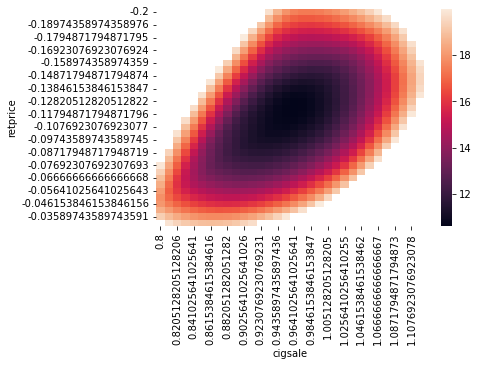

In [7]:
df_loss = pd.DataFrame(cordinates, columns=["retprice", "cigsale", "loss"]).query("loss<20")

sns.heatmap(df_loss.pivot("retprice", "cigsale", "loss"))

## Everything Together

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp
from scipy.optimize import minimize


class SyntheticControl(object):

    def __init__(self,
                 time_column,
                 geo_column,
                 y_column,
                 x_columns,
                 post_column,
                 tr_column):
        
        self.time_column = time_column
        self.geo_column = geo_column
        self.y_column = y_column
        self.x_columns = x_columns
        self.post_column = post_column
        self.tr_column = tr_column
        
    
    def fit(self, df):
        
        x_co_list = build_x_matrix(df.query(f"~{self.post_column} & ~{self.tr_column}"),
                                   time_column=self.time_column,
                                   geo_column=self.geo_column,
                                   x_columns=self.x_columns)
        
        y_tr_pre = df.query(f"~{self.post_column}").query(f"{self.tr_column}")[self.y_column]
        

        def v_loss(vs):
            return find_w_given_vs(vs, x_co_list, y_tr_pre).get("loss")
        
       
        v_solution = minimize(v_loss, [0, 0], method='L-BFGS-B')
        
        self.w = find_w_given_vs(v_solution.x, x_co_list, y_tr_pre).get("w")
        self.v = v_solution.x
        
        
    def predict(self, df):
        
        x_co_list = build_x_matrix(df.query(f"~{self.tr_column}"),
                                   time_column=self.time_column,
                                   geo_column=self.geo_column,
                                   x_columns=self.x_columns)
        
        X_times_v = sum([x*v for x, v in zip(x_co_list, self.v)])
        X = check_array(X_times_v)
        
        return X @ self.w
        
        return self.y_scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()

## Use Model with Covariates

In [9]:
# model with 2 covariates
model1 = SyntheticControl(
    time_column="year",
    geo_column="state",
    y_column="cigsale",
    x_columns=["retprice", "cigsale"],
    post_column="after_treatment",
    tr_column="california"
)


# model with 1 covariates (Outcome)
model2 = SyntheticControl(
    time_column="year",
    geo_column="state",
    y_column="cigsale",
    x_columns=["cigsale"],
    post_column="after_treatment",
    tr_column="california"
)


model1.fit(df)
model2.fit(df)

In [10]:
model1.w.round(1)

array([-0. , -0. ,  0. ,  0.4,  0. , -0. ,  0.1,  0.1, -0. , -0. ,  0.1,
       -0. , -0. , -0. , -0. , -0. , -0. ,  0. ,  0.1,  0.1, -0. , -0. ,
        0.1, -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0. ,
       -0. , -0. ,  0. , -0. , -0. ])

In [11]:
model1.v

array([-0.12344947,  0.96484268])

In [12]:
sc1 = model1.predict(df)
sc2 = model2.predict(df)

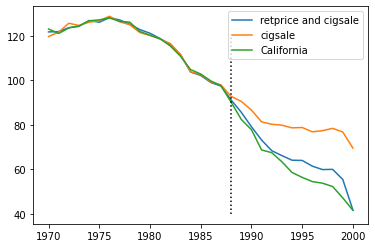

In [13]:
x = df.query("california")["year"]

plt.plot(x, sc1, label="retprice and cigsale")
plt.plot(x, sc2, label="cigsale")
plt.plot(x, df.query("california")["cigsale"].values, label="California")
plt.vlines(df.query("after_treatment")["year"].min()-1, 40, 120, color="black", ls="dotted")
plt.legend();